In [2]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Architecture:
- VGG16
- Decoder

# VGG16

- We take the first 19 layers (basically all the layers before the last dense layers)
- We set to FALSE the trainable parameters
- We take an input image from the LAB format so We need to make the right adjustments!
- we need to process the images to the right size!

In [4]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16()
newmodel = Sequential() 
for i, layer in enumerate(vggmodel.layers):
    if i<19:          
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   # to NOT train these layers

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from pathlib import Path
import imghdr

data_dir = "/Users/simoneboesso/Downloads/archive-5/musemart/dataset_updated/training_set"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

/var/folders/f7/gd5km_f51z3b_0fkjn895nt80000gn/T/ipykernel_3888/214132567.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
train_path = '/Users/simoneboesso/Downloads/archive-5/musemart/dataset_updated/training_set'
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

train = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode=None)

Found 3715 images belonging to 5 classes.


In [7]:
batch = next(train)
print("Batch shape:", batch[0].shape)  # Should be (batch_size, 224, 224, 3)
print("Single image shape:", batch[0][0].shape) 

Batch shape: (224, 224, 3)
Single image shape: (224, 3)


In [8]:
train.samples 

3715

In [9]:
train.batch_size

32

In [ ]:
X = []
Y = []

# Get the total number of batches
num_batches = int(np.ceil(train.samples / train.batch_size))

batch_index = 0
while batch_index < num_batches:
    batch = next(train)  # Get the next batch
    for img in batch:  # Iterate through images in the batch
        try:
            lab = rgb2lab(img)  # Convert to LAB
            X.append(lab[:, :, 0])  # Store the L channel
            Y.append(lab[:, :, 1:] / 128)  # Normalize and store A and B channels
        except Exception as e:
            print(f'Error processing image: {e}')
    batch_index += 1  # Increment the batch index

print(f'Processed {len(X)} images.')

# Converting to LAB
- Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
- The input to the network will be the L channel,

In [24]:
X = np.array(X)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(3715, 224, 224, 1)
(3715, 224, 224, 2)


In [25]:
X.shape

(3715, 224, 224, 1)

In [26]:
Y.shape

(3715, 224, 224, 2)

In [ ]:
from tqdm import tqdm
## Adjustments for VGG16
## Just repeating the L layer 3 times!
vggfeatures = []
for i, sample in tqdm(enumerate(X), total=len(X)):
  sample = gray2rgb(sample) ## here the repeat!
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  # Here the reshaping from  (1, 7, 7, 512) to (7,7,512)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

# ARCHITECTURE

In [ ]:
#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same')) ## tanh since A and B goes from -1 to 1
model.add(UpSampling2D((2, 2)))
model.summary()

In [32]:
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, verbose=1, epochs=10, batch_size=128)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 627ms/step - accuracy: 0.6269 - loss: 0.4147
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 586ms/step - accuracy: 0.7275 - loss: 0.0123
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 554ms/step - accuracy: 0.7741 - loss: 0.0098
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 573ms/step - accuracy: 0.8245 - loss: 0.0086
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 620ms/step - accuracy: 0.8312 - loss: 0.0078
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 605ms/step - accuracy: 0.8281 - loss: 0.0076
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 638ms/step - accuracy: 0.8293 - loss: 0.0076
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 592ms/step - accuracy: 0.8197 - loss: 0.0074
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 568ms/step - accuracy: 0.8252 - loss: 0.0070
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 570ms/step - accuracy: 0.8287 - loss: 0.0074


# TEST TIME

In [34]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale images

test_generator = test_datagen.flow_from_directory(
    '/Users/simoneboesso/Downloads/archive-5/musemart/dataset_updated/validation_set',  # Update this path if needed
    target_size=(224, 224),
    batch_size=32,  # Or another batch size that suits your needs
    class_mode=None,  # Since we're only predicting, not training
    shuffle=False  # Keep data in same order as filenames
)

Found 271 images belonging to 5 classes.


In [45]:
X_test = []
Y_test = []

# Get the total number of batches
num_batches = int(np.ceil(test_generator.samples / test_generator.batch_size))

batch_index = 0
while batch_index < num_batches:
    batch = next(train)  # Get the next batch
    for img in batch:  # Iterate through images in the batch
        try:
            lab = rgb2lab(img)  # Convert to LAB
            X_test.append(lab[:, :, 0])  # Store the L channel
            Y_test.append(lab[:, :, 1:] / 128)  # Normalize and store A and B channels
        except Exception as e:
            print(f'Error processing image: {e}')
    batch_index += 1  # Increment the batch index

print(f'Processed {len(X)} images.')

Processed 3715 images.


In [47]:
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [48]:
X_test.shape

(288, 224, 224)

In [49]:
X_test[0].max()

99.44676

In [50]:
Y_test[0].max()

0.39339736

In [51]:
X_test = X_test.reshape(X_test.shape+(1,)) #dimensions to be the same for X and Y
print(X_test.shape)
print(Y_test.shape)

(288, 224, 224, 1)
(288, 224, 224, 2)


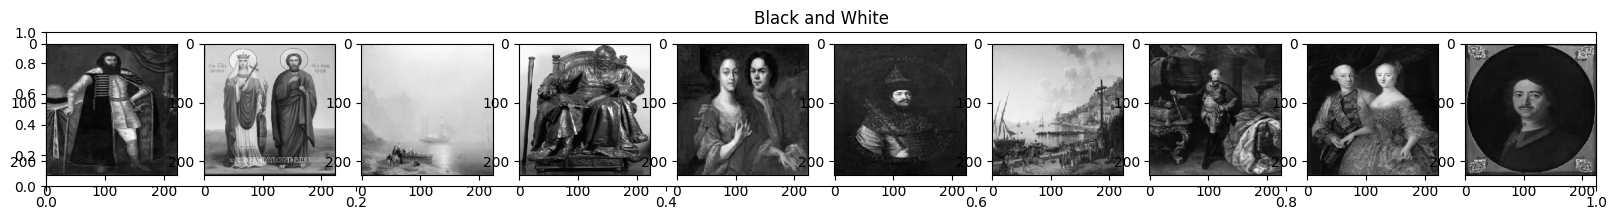

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 2))
plt.title("Black and White")
for i in range(1,11):
    ax = plt.subplot(1, 10, i)
    img = X_test[i]
    plt.imshow(img,cmap="gray")
plt.show()

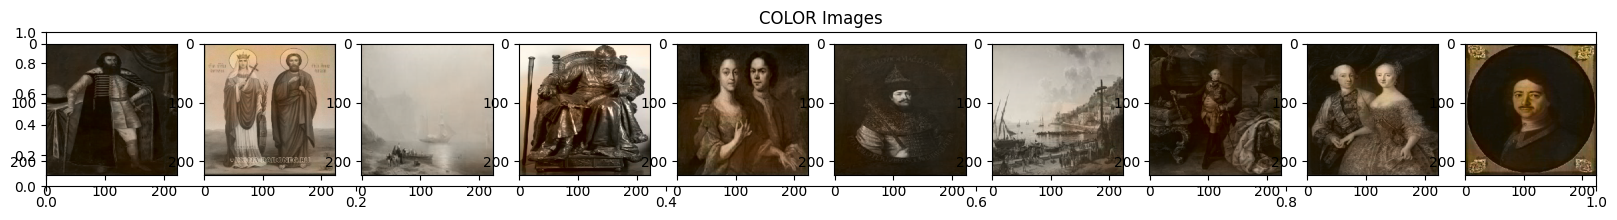

In [63]:
plt.figure(figsize=(20, 2))
plt.title("COLOR Images")
for i in range(1,11):
    ax = plt.subplot(1, 10, i)
    img = X_test[i]
    img_reshaped= gray2rgb(img) ## here the repeat!
    img_reshaped =  img_reshaped.reshape((1,224,224,3))
    vggpred = newmodel.predict(img_reshaped, verbose=0)
    ab = model.predict(vggpred,verbose=0)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    img = np.squeeze(img)
    cur[:,:,0] = img

    cur[:,:,1:] = ab
    rgb_image = lab2rgb(cur)
    plt.imshow(rgb_image)
plt.show()